# Feature_Engineering
---

## 0. Constants

In [69]:
RAW_DATA_PATH = "../data/raw.csv"
TRAIN_DATA_PATH = "../data/processed/train.csv"
TEST_DATA_PATH = "../data/processed/test.csv"

PREPROCESSOR_PATH = "../artifacts/preprocessor.pkl"

---
## 1. Imports

In [73]:
import os
import pickle 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import sklearn
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier


from xgboost import XGBClassifier

In [3]:
bookings_df = pd.read_csv(RAW_DATA_PATH)
bookings_df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


## 1.1 Functions

In [19]:
def calculate_mi_scores(X, y):
    """Calculates Mutual Information scores of non-linear relationships between features 'X' & target 'y'. """
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values(ascending=False).to_frame()
    return mi_scores

In [68]:
def save_pickle_object(obj, file_path):
    """Serialize Python object as pickle object"""
    
    #create directory if not yet existing
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    #save the object in the file
    with open(file_path, "wb") as file:
        pickle.dump(obj, file)

---
## 2. Preprocessing

In [62]:
X= bookings_df.drop('booking_complete',axis=1)
y= bookings_df.booking_complete         

In [11]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

X["flight_day"] = X["flight_day"].map(mapping)

In [61]:
encoder = OrdinalEncoder()

In [65]:
obj_cols = X.select_dtypes("object").columns
X[obj_cols] = encoder.fit_transform(X[obj_cols])
X.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
0,2,0.0,2.0,262,19,7,2.0,0.0,61.0,1,0,0,5.52
1,1,0.0,2.0,112,20,3,2.0,0.0,61.0,0,0,0,5.52
2,2,0.0,2.0,243,22,17,6.0,0.0,36.0,1,1,0,5.52
3,1,0.0,2.0,96,31,4,2.0,0.0,61.0,0,0,1,5.52
4,2,0.0,2.0,68,22,15,6.0,0.0,36.0,1,0,1,5.52


In [64]:
X.dtypes

num_passengers             int64
sales_channel            float64
trip_type                float64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day               float64
route                    float64
booking_origin           float64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
dtype: object

In [12]:
# #changing object dtype to int dtype
# for colname in X.select_dtypes("object").columns:
#     X[colname], _ = X[colname].factorize()

In [66]:
# X.head()

In [67]:
# X.dtypes

### Mutual Information

In [20]:
mi_scores = calculate_mi_scores(X, y)

mi_scores 

,MI Scores
route,0.052483
booking_origin,0.045339
flight_duration,0.017379
length_of_stay,0.009515
wants_extra_baggage,0.009318
wants_in_flight_meals,0.004657
flight_hour,0.003912
sales_channel,0.002735
wants_preferred_seat,0.002250
purchase_lead,0.001361


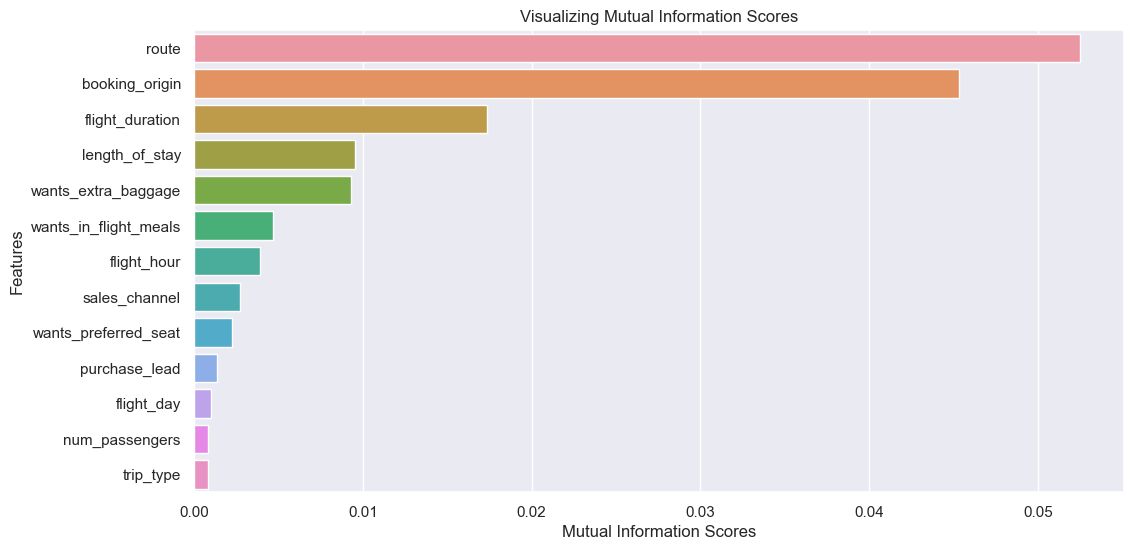

In [21]:
#plot the feature importances
plt.figure(figsize=(12,6))
sns.barplot(data = mi_scores, x="MI Scores", y=mi_scores.index)
plt.xlabel('Mutual Information Scores')
plt.ylabel('Features')
plt.title("Visualizing Mutual Information Scores")
plt.show()

### Correlation

<Axes: >

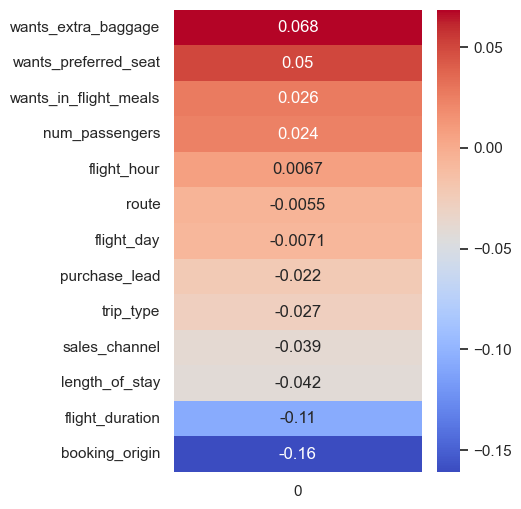

In [28]:
fig = plt.figure(figsize=(4,6))
sns.heatmap(X.corrwith(y).to_frame().sort_values(by=0 ,ascending=False), annot=True, cmap= 'coolwarm')

>**We can see that mutual information has different values than correlation values, this is probably due to nonlinear relationship between features & target.** 

### Feature Importance

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [33]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train) 

RandomForestClassifier()

In [34]:
features_importance = pd.Series(rf.feature_importances_, name="Features Importance", index=X_train.columns).to_frame()
features_importance = features_importance.sort_values(by="Features Importance", ascending=False)

features_importance

,Features Importance
purchase_lead,0.192953
route,0.150832
flight_hour,0.141083
length_of_stay,0.125470
booking_origin,0.110257
flight_day,0.091784
flight_duration,0.072691
num_passengers,0.049205
wants_in_flight_meals,0.020117
wants_preferred_seat,0.017115


>**Feature Importance give closer results to mutual information. In training, we will consider training with the top features & evaluate the results.**

---
## 3. Save final data

In [35]:
final_train_data = pd.concat([X_train,y_train],axis=1)
final_test_data = pd.concat([X_test,y_test],axis=1)

In [37]:
final_train_data.to_csv(TRAIN_DATA_PATH, index=False, header=True)
final_test_data.to_csv(TEST_DATA_PATH, index=False, header=True)

In [74]:
save_pickle_object(encoder, PREPROCESSOR_PATH)